In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, gzip
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

## Exercise 1

Load MNIST and train an RBM. Remember to **normalize** pixel luminosities to the [0-1] interval.

In [40]:
from keras import datasets
from sklearn.preprocessing import StandardScaler
mnist = pd.read_csv("data/mnist1.5k.csv.gz", compression="gzip", header=None).values
numbers_X = mnist[:,1:785]/255
numbers_y = mnist[:,0]
print numbers_X.shape, numbers_y.shape


(1500, 784) (1500,)


the following code counts the numbers of instances for each digit and a sample of the dataset.

In [3]:
print "TRAIN numbers class distribution"
pd.DataFrame(pd.Series(numbers_y).value_counts()).T


TRAIN numbers class distribution


,2,1,7,6,4,0,9,8,5,3
0,186,157,154,152,151,150,146,141,138,125


In [4]:
def show_linearized_images_sample(X, n_images=200, permutation=True):
    plt.figure(figsize=(18,8))
    Xp = np.random.permutation(X) if permutation else X
    img =  np.rollaxis(np.rollaxis(Xp[:n_images].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.axis("off")

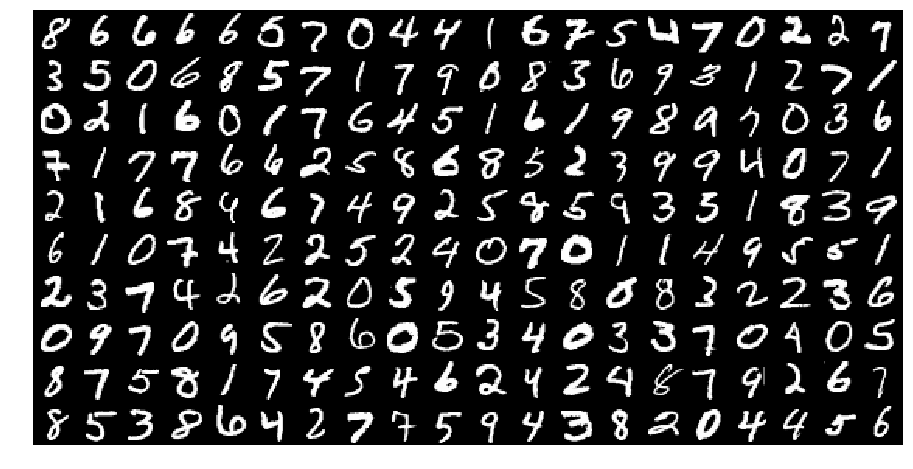

In [5]:
show_linearized_images_sample(numbers_X)


create and train an RBM with 100 components, batch_size 5, learning_rate 0.1 and 100 iterations with `numbers_X`

In [6]:
from sklearn.neural_network import BernoulliRBM

rbm = BernoulliRBM(n_components=100, batch_size=5, learning_rate=0.1,n_iter=100, random_state=None, verbose=0)
rbm.fit(numbers_X);
c, b, W = rbm.intercept_visible_, rbm.intercept_hidden_, rbm.components_

### obtain the `W` matrix and plot the 100 components from the trained RBM (matrix `W`)

you should see something approximately like this

![alt text](./Images/lab_rbm_components.png)

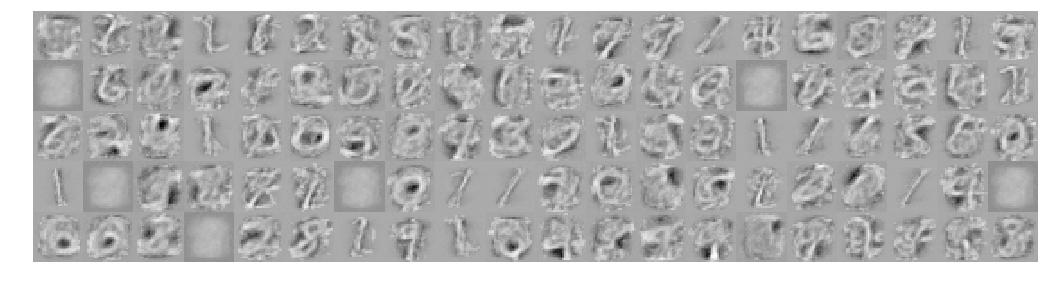

In [8]:
show_linearized_images_sample(W, n_images=len(W))

## Exercise 2

- Load into `fashion_X` 1500 fashion MNIST images and do not forget to normalize their luminosity to the  [0-1] interval.
- Create 1500 random noise images into a variable named `random_imgs` (use `np.random.random(size=(1500,784))`) and set to zero any value under 0.7
- Use the previously trained RBM to compute the free energy of all elements in `fashion_X`, `number_X` , `number_X_sel` and `random_imgs`.
- Plot the histograms. You should see a clear separation of the four datasets.

Your histogram should look roughly like this

![alt text](./Images/lab_rbm_histograms.png)



In [9]:
from keras import datasets
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
X_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

fashion_X = X_train[:1500,:]/255

In [52]:
def free_energy(v,c,b,W):
    return - v.dot(c)- np.logaddexp(0, v.dot(W.T) + b).sum() 

def calculate_free_energy(X_domain, c,b,W):
    
    energies = np.r_[[free_energy(i,c,b,W) for i in X_domain]]    
    return energies

In [53]:
random_imgs = np.random.random(size=(1500,784))


In [54]:
fashion_energy=calculate_free_energy(fashion_X, c,b,W)
number_energy=calculate_free_energy(numbers_X, c,b,W)
random_energy=calculate_free_energy(random_imgs, c,b,W)

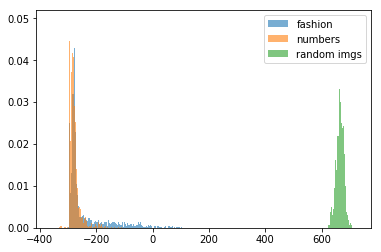

In [60]:
plt.hist(fashion_energy, bins=100, label='fashion', alpha=0.6,normed=True);
plt.hist(number_energy, bins=100, label='numbers', alpha=0.6,normed=True);
plt.hist(random_energy, bins=100, label='random imgs', alpha=0.6, normed=True);

plt.legend()

## Exercise 3: 

Select a random set of 40 digits and perform a 100 steps Gibbs sampling for each one of them. 

Follow the example here: https://www.kaggle.com/nicw102168/restricted-boltzmann-machine-rbm-on-mnist

Your generation might look like:

![alt text](./Images/lab_rbm_generated.png)




In [56]:
X_40 = X_train[:40].copy()

In [57]:
for i in range(100):
    for n in range(40):
        X_40[n] = rbm.gibbs(X_40[n])

<Figure size 720x1440 with 0 Axes>

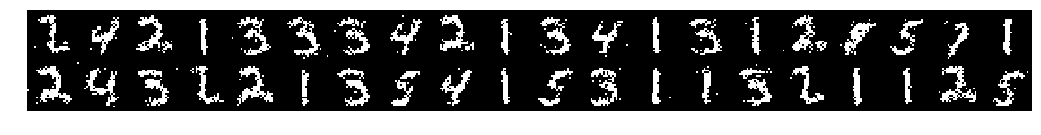

In [59]:
plt.figure(figsize=(10,20))
show_linearized_images_sample(X_40, len(X_40), permutation=False)

## Exercise 4

Select a simple sklearn classification method (such as GaussianNB or LogisticRegression), make a random train/test split of 50% on MNIST digits and then:

- train and measure the performance of your selected method directly with the raw MNIST data
- train and measure the perofrmance of your selected method **after** transforming MNIST data with the previously trained RBM

you should see some improvement after transforming the data.

In [19]:
from sklearn.model_selection import train_test_split

mnist = pd.read_csv("data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
print(X_train.shape)

(750, 784)


In [41]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(random_state=0).fit(X_train, y_train)

preds = clf.predict(X_test)
print(clf.score(X_test,y_test))

acc_reg = np.mean(preds == y_test)
print('Accuracy = ', acc_reg*100, '%')

print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        y_test,
        clf.predict(X_test))))


0.8586666666666667
('Accuracy = ', 85.86666666666667, '%')
Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.89      1.00      0.94        74
          1       0.85      0.93      0.89        75
          2       0.95      0.77      0.85        94
          3       0.82      0.86      0.84        63
          4       0.84      0.91      0.87        76
          5       0.85      0.75      0.80        71
          6       0.92      0.93      0.92        72
          7       0.94      0.89      0.91        88
          8       0.75      0.72      0.74        68
          9       0.74      0.84      0.79        69

avg / total       0.86      0.86      0.86       750




In [51]:
from sklearn.pipeline import Pipeline
from sklearn import metrics
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', clf)])


# Training RBM-Logistic Pipeline
classifier.fit(X_train, y_train)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        y_test,
        classifier.predict(X_test))))


Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.88      0.96      0.92        74
          1       0.92      0.97      0.95        75
          2       0.90      0.84      0.87        94
          3       0.84      0.83      0.83        63
          4       0.84      0.83      0.83        76
          5       0.93      0.79      0.85        71
          6       0.93      0.92      0.92        72
          7       0.92      0.76      0.83        88
          8       0.68      0.84      0.75        68
          9       0.73      0.81      0.77        69

avg / total       0.86      0.85      0.85       750


